<a href="https://colab.research.google.com/github/3mirSahin/MLProjects/blob/main/License_Plate_Detector_and_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#License Plate Detector and Recognizer

This is a model utilizing tesseract and images off of a Kaggle dataset to train a YOLOv5 model on recognizing license plates and using tesseract to determine the license plate number.

This is an attempt at learning to utilize tesseract.

https://techvidvan.com/tutorials/python-project-license-number-plate-recognition/

https://towardsdatascience.com/ai-based-indian-license-plate-detector-de9d48ca8951

https://www.kaggle.com/alpertemel/plate-number-detection

##Setting Up the Environment

In [1]:
#Tesseract installation
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 40 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (3,058 kB/s)
debconf: unable to initi

In [32]:
#Installing YOLOv5
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt  # install dependencies

import torch
from IPython.display import Image, clear_output  # to display images
import matplotlib.pyplot as plt

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.9.0+cu102 (Tesla T4)


In [3]:
!echo "train: Dataset/train/images" > data/alpr.yaml
!echo "val:   Dataset/train/images" >> data/alpr.yaml

!echo "nc : 1" >> data/alpr.yaml
!echo "names: ['license']" >> data/alpr.yaml

!cat data/alpr.yaml

train: Dataset/train/images
val:   Dataset/train/images
nc : 1
names: ['license']


In [5]:
#Pulling the data from kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d andrewmvd/car-plate-detection
!unzip car-plate-detection.zip

 99% 201M/203M [00:04<00:00, 31.8MB/s]
100% 203M/203M [00:04<00:00, 51.6MB/s]
Archive:  car-plate-detection.zip
  inflating: annotations/Cars0.xml   
  inflating: annotations/Cars1.xml   
  inflating: annotations/Cars10.xml  
  inflating: annotations/Cars100.xml  
  inflating: annotations/Cars101.xml  
  inflating: annotations/Cars102.xml  
  inflating: annotations/Cars103.xml  
  inflating: annotations/Cars104.xml  
  inflating: annotations/Cars105.xml  
  inflating: annotations/Cars106.xml  
  inflating: annotations/Cars107.xml  
  inflating: annotations/Cars108.xml  
  inflating: annotations/Cars109.xml  
  inflating: annotations/Cars11.xml  
  inflating: annotations/Cars110.xml  
  inflating: annotations/Cars111.xml  
  inflating: annotations/Cars112.xml  
  inflating: annotations/Cars113.xml  
  inflating: annotations/Cars114.xml  
  inflating: annotations/Cars115.xml  
  inflating: annotations/Cars116.xml  
  inflating: annotations/Cars117.xml  
  inflating: annotations/Cars118.x

In [6]:
import numpy as np
import cv2
from PIL import Image
import pytesseract as tess
import os
import numpy as np
from pathlib import Path
from xml.dom.minidom import parse
from shutil import copyfile
from IPython.display import Image

##Training a Plate Detection Algorithm

###Dataset Preperation
Here, we prepare the dataset for the YOLOv5 model the use such as converting COCO Annotations to YOLOv5 labels.

Keep in mind that COCO annotations are usually used in FasterRCNN and the likes.

In [7]:
#determining the pathing and creating training and validation sets
IMAGE_PATH = "images"
ANNOTATIONS_PATH = "annotations"

DATA_ROOT = "Dataset/"
DEST_IMAGES_PATH = "train/images"
DEST_LABELS_PATH = "train/labels"

!mkdir -p Dataset/train/labels

!mkdir -p Dataset/train
!cp -rf images Dataset/train

!mkdir -p Dataset/val
!cp -rf images/Cars1*.png Dataset/val

In [8]:
#Converting the COCO annotations into YOLOv5 annotations - functions

def cord_converter(size, box):
  """
  Convert xml annotations to darknet format coordinates:
  parameter size = [w, h]
  param box = anchor box coordinates [upper-left x, upper-left y, lower-right x, lower-right y]
  return = converted [x,y,w,h]
  """

  x1 = int(box[0])
  y1 = int(box[1])
  x2 = int(box[2])
  y2 = int(box[3])

  dw = np.float32(1. / int(size[0]))
  dh = np.float32(1. / int(size[1]))

  w = x2 - x1
  h = y2 - y1
  x = x1 + (w / 2)
  y = y1 + (h / 2)

  x = x * dw
  w = w * dw
  y = y * dh
  h = h * dh
  return [x, y, w, h]

def save_file(img_jpg_file_name, size, img_box):
  """
  Saves the YOLOv5 compatible coordinates as a txt file
  """
  classes = ['license']
  save_file_name = DATA_ROOT + DEST_LABELS_PATH + '/' + img_jpg_file_name + '.txt'
  print(save_file_name)
  file_path = open(save_file_name, "a+")
  for box in img_box:                  
  #cls_num = classes.index(box[0]) # find class_id
    cls_num = 0
    new_box = cord_converter(size, box[1:]) # convert box coord into YOLO x,y,w,h

    file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

  file_path.flush()
  file_path.close()

def get_xml_data(file_path, img_xml_file):
  """
  Snatches the coordinates from the XML file
  """
  img_path = file_path + '/' + img_xml_file + '.xml'
  print(img_path)

  dom = parse(img_path)
  root = dom.documentElement
  img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
  img_size = root.getElementsByTagName("size")[0]
  objects = root.getElementsByTagName("object")
  img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
  img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
  img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
    # print("img_name:", img_name)
    # print("image_info:(w,h,c)", img_w, img_h, img_c)
  img_box = []
  for box in objects:
    cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
    x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
    y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
    x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
    y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
    print("box:(c,xmin,ymin,xmax,ymax)", cls_name, x1, y1, x2, y2)
    img_jpg_file_name = img_xml_file + '.jpg'
    img_box.append([cls_name, x1, y1, x2, y2])
    # print(img_box)
    # test_dataset_box_feature(img_jpg_file_name, img_box)
  save_file(img_xml_file, [img_w, img_h], img_box)

In [9]:
files = os.listdir(ANNOTATIONS_PATH)
for file in files:
  print("File Name: ", file)
  file_xml = file.split(".")
  get_xml_data(ANNOTATIONS_PATH, file_xml[0])

File Name:  Cars170.xml
annotations/Cars170.xml
box:(c,xmin,ymin,xmax,ymax) licence 318 190 346 224
Dataset/train/labels/Cars170.txt
File Name:  Cars308.xml
annotations/Cars308.xml
box:(c,xmin,ymin,xmax,ymax) licence 159 221 237 241
Dataset/train/labels/Cars308.txt
File Name:  Cars324.xml
annotations/Cars324.xml
box:(c,xmin,ymin,xmax,ymax) licence 151 138 255 159
Dataset/train/labels/Cars324.txt
File Name:  Cars323.xml
annotations/Cars323.xml
box:(c,xmin,ymin,xmax,ymax) licence 123 28 279 65
Dataset/train/labels/Cars323.txt
File Name:  Cars178.xml
annotations/Cars178.xml
box:(c,xmin,ymin,xmax,ymax) licence 126 180 173 205
Dataset/train/labels/Cars178.txt
File Name:  Cars319.xml
annotations/Cars319.xml
box:(c,xmin,ymin,xmax,ymax) licence 167 228 232 259
Dataset/train/labels/Cars319.txt
File Name:  Cars50.xml
annotations/Cars50.xml
box:(c,xmin,ymin,xmax,ymax) licence 116 55 525 262
Dataset/train/labels/Cars50.txt
File Name:  Cars156.xml
annotations/Cars156.xml
box:(c,xmin,ymin,xmax,ymax)

In [10]:
#Add the validation labels
!mkdir -p Dataset/val/labels
!cp -rf Dataset/train/labels/Cars1*.txt Dataset/val/labels

###YOLOv5 Training
Here, we train the YOLOv5 model using the data acquired.

In [12]:
!python train.py --img 416 --batch 16 --epochs 300 --data data/alpr.yaml --cfg models/yolov5s.yaml

train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=data/alpr.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=300, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1, freeze=0
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v5.0-375-gd1182c4 torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=

##Detection
Here, we will detect annotations using YOLOv5, crop them, and feed them into tesseract to get a result.

In [13]:
%cd ..
!git clone https://github.com/openalpr/benchmarks

/content
Cloning into 'benchmarks'...
remote: Enumerating objects: 1752, done.
remote: Total 1752 (delta 0), reused 0 (delta 0), pack-reused 1752
Receiving objects: 100% (1752/1752), 187.98 MiB | 35.06 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [14]:
%cd yolov5

/content/yolov5


In [75]:
!python detect.py --source ../benchmarks/endtoend/us --conf 0.4 --weights runs/train/exp/weights/best.pt --save-txt

detect: weights=['runs/train/exp/weights/best.pt'], source=../benchmarks/endtoend/us, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, tfl_int8=False
YOLOv5 🚀 v5.0-375-gd1182c4 torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 224 layers, 7053910 parameters, 0 gradients, 16.3 GFLOPs
image 1/222 /content/yolov5/../benchmarks/endtoend/us/0b86cecf-67d1-4fc0-87c9-b36b0ee228bb.jpg: 384x640 1 license, Done. (0.012s)
image 2/222 /content/yolov5/../benchmarks/endtoend/us/12c6cb72-3ea3-49e7-b381-e0cdfc5e8960.jpg: 384x640 Done. (0.010s)
image 3/222 /content/yolov5/../benchmarks/endtoend/us/1e241dc8-8f18-4955-8988-03a0ab49f813.jpg: 384x640 1 license, Done. (0.011s)
image 4/2

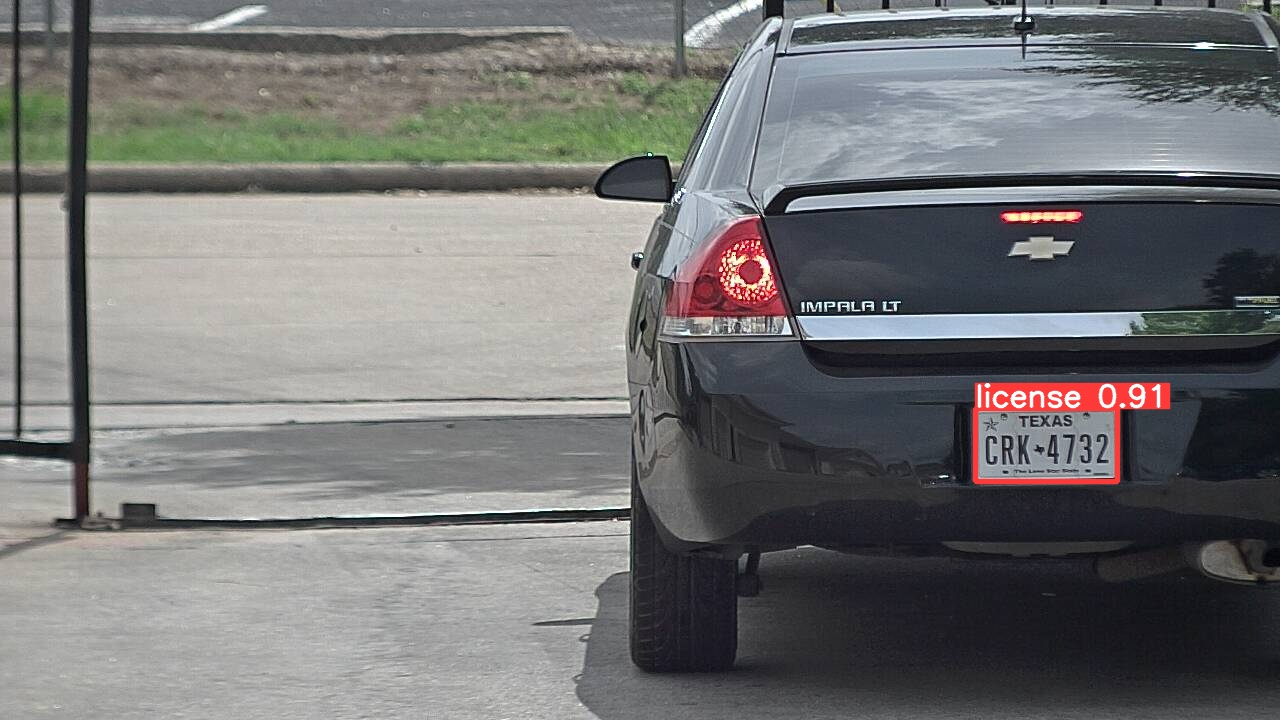

In [76]:
from IPython.display import Image
#displaying a random image
Image('runs/detect/exp2/wts-lg-000129.jpg')


####OCR and Cropping

In [145]:
# read .txt to get x,y,w,h of the image
def read_txt(filepath):
    f = open(filepath, 'r')
    lines = f.readlines()

    # read objects from each line of .txt
    objects = []
    for line in lines:
        line=line.rstrip()
        #need to turn the given coordinates 0-1 scale to image scale:
        obj = [float(i) for i in line.split(' ')]
        objects.append(obj)
    #print(objects)
    return objects

In [222]:
import os, random
DETECT_PATH = 'runs/detect/exp2/'
IMG_NAME    = os.path.splitext(random.choice(os.listdir("runs/detect/exp2/")))[0]

In [224]:
print(IMG_NAME)

wts-lg-000047


In [218]:
#license plate cleaning
def cleanPlate(im):
  #resize
  width = int(im.shape[1] * 3)
  height = int(im.shape[0] * 3)
  dim = (width, height)
  imr = cv2.resize(im,dim,interpolation = cv2.INTER_CUBIC)
  gray = cv2.cvtColor(imr, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray,(5,5),0)
  
  return blurred

cLT-0108



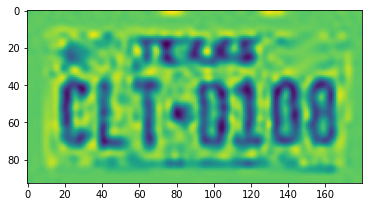

In [223]:
import pytesseract as tess

# print(DETECT_PATH+IMG_NAME+'.jpg')
# print(DETECT_PATH +'labels/'+IMG_NAME+'.txt')
img = cv2.imread(DETECT_PATH+IMG_NAME+'.jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
lics = read_txt(DETECT_PATH +'labels/'+IMG_NAME+'.txt')
dh, dw, _ = img.shape

#https://stackoverflow.com/questions/64096953/how-to-convert-yolo-format-bounding-box-coordinates-into-opencv-format
for lic in lics:
    c, x, y, w, h = lic
    # print(x,y,w,h) # center of the bounding box
    l = int((x-w/2)*dw)
    r = int((x + w / 2) * dw)
    t = int((y - h / 2)*dh)
    b = int((y+h/2)*dh)

    if l < 0:
      l = 0
    if r > dw - 1:
      r = dw - 1
    if t < 0:
      t = 0
    if b > dh - 1:
      b = dh - 1
    # print(l,r,t,b)
    # img_alpr = img[y-int(h/2):y+int(h/2),x-int(w/2):x+int(w/2)]
    img_alpr = img[t:b,l:r]
    # print(img_alpr)
    # plt.imshow(img_alpr)
    #now some editing to the image
    img_edit = cleanPlate(img_alpr)
    plt.imshow(img_edit)
    txt = tess.image_to_string(img_edit, config ='--oem 3 --psm 10')
print(txt)

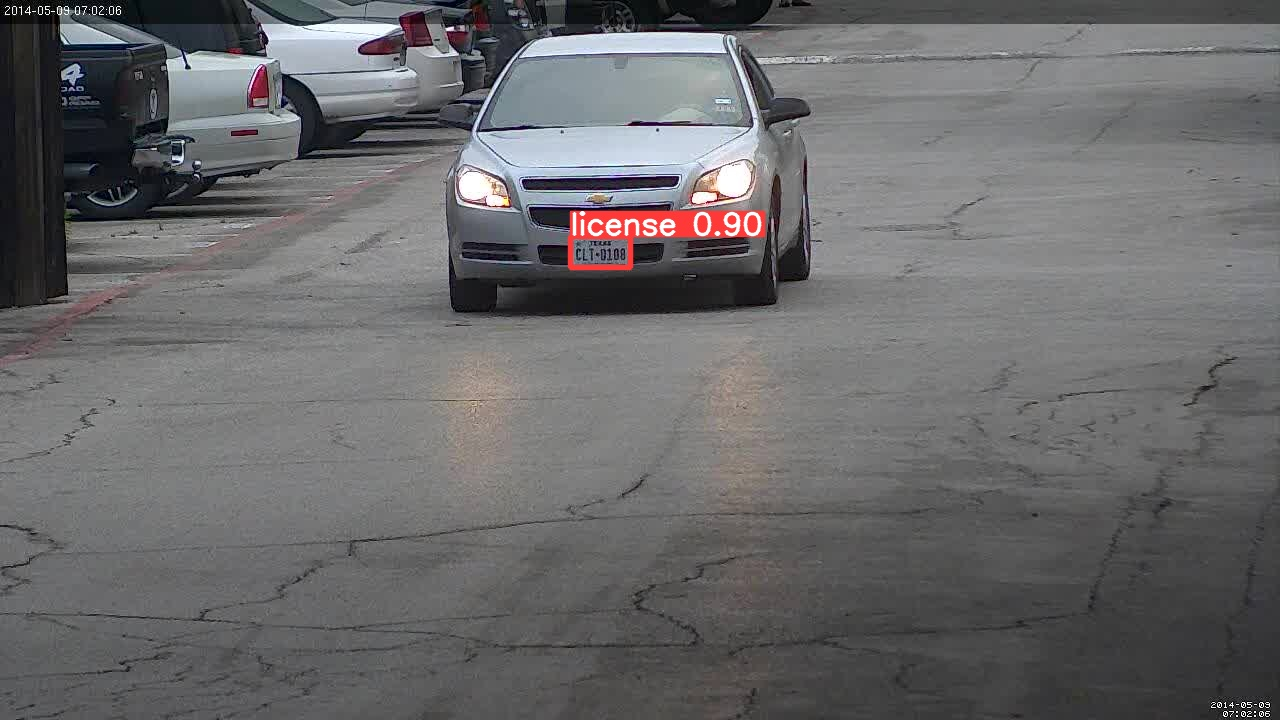

In [226]:
#Image of the car
Image(DETECT_PATH+IMG_NAME+'.jpg')

##Plate Detection -- Ignore as this is not being utilized
In this part, we aim to detect the license plate location. While the main reason this dataset was created was to train a model to do this detection process, we'll aim to solve this by using OpenCV.

###Plate Detection
The following function utilizes OpenCV to provide a new image, specifically of the plate, of a given image. It uses the image path as an input.

The process is as follows:


1.   RGB to Grayscale conversion - easier to process, fewer channels
2.   Smoothening - using bilateral smoothening, we smooth out the image to remove 'noise.' Plate information tends to stay intact in this process.
3.   Edge detection - after the image is smoothened out, there will only be certain edges that will be recognized and a group of this will be the license plate and its symbols.
4. Countouring - This combines all the areas that are of the same color and depth. Thanks to the previous smoothening and edge detection, these should provide us with an outline of the license plate.

Now, to determine the 'best possible' location for the license plate, we utilize several checks:


*   Area range and width-height ratio
*   Average of the image matrix
*   Rotation of contours

This results in the following:






In [ ]:
from google.colab.patches import cv2_imshow

#Ratio checker:
def ratioCheck(area, width, height):
  ratio = float(width) / float(height)
  if ratio <1:
    ratio = 1/ ratio
  if (area < 1063.62 or area > 73862.5) or (ratio < 3 or ratio > 6):
    return False
  return True

#Average of image matrix to check the white:
def isMaxWhite(plate):
  avg = np.mean(plate)
  if (avg >= 115):
    return True
  else:
    return False

#Rotation of Contours
def ratiorotate(rect):
  (x,y), (width,height),rect_angle=rect

  if (width>height):
    angle = -rect_angle
  else:
    angle = 90 + rect_angle
  
  if angle > 15:
    return False
  
  if height == 0 or width == 0:
    return False
  
  area = height*width

  if not ratioCheck(area,width,height):
    return False
  else:
    return True

#Plate Detection in given image:
def givePlate(path):
  img = cv2.imread(path)
  plate_img = img.copy()
	
	#Loads the data required for detecting the license plates from cascade classifier.
	plate_cascade = cv2.CascadeClassifier('./indian_license_plate.xml')

	# detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
	plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.3, minNeighbors = 7)

	for (x,y,w,h) in plate_rect:
		a,b = (int(0.02*img.shape[0]), int(0.025*img.shape[1])) #parameter tuning
		plate = plate_img[y+a:y+h-a, x+b:x+w-b, :]
		# finally representing the detected contours by drawing rectangles around the edges.
		cv2.rectangle(plate_img, (x,y), (x+w, y+h), (51,51,255), 3)
        
	return plate_img, plate # returning the processed image